In [38]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
iris = sns.load_dataset('iris')


In [39]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data),dtype=torch.long )
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [40]:
train_data,test_data,train_labels,test_labels = \
                                      train_test_split(data,labels,train_size= .8)
train_data =TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
train_loader = DataLoader(train_data,shuffle=True,batch_size= 64,drop_last = True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [41]:
def createANewmodel():
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
    )
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr = 0.005)
  return ANNiris,lossfun,optimizer

In [42]:
numepochs = 1000
def trainmodel(L1lambda):
    trainAcc = []
    testAcc = []
    losses = []
    nweights = 0

    for pname, weight in ANNiris.named_parameters():
        if 'bias' not in pname:
            nweights += weight.numel()

    for epochi in range(numepochs):
        batchAcc = []
        batchLoss = []

        for x, y in train_loader:

            yHat = ANNiris(x)
            loss = lossfun(yHat, y)


            L1_term = torch.tensor(0.0)
            for pname, weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term += torch.sum(torch.abs(weight))

            loss = loss + L1lambda * L1_term / nweights


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            batchLoss.append(loss.item())


        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))


        x, y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(x), axis=1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

    return trainAcc, testAcc, losses

In [43]:
ANNiris,lossfun,optimizer = createANewmodel()
L1lambda =.001
trainAcc,testAcc,losses = trainmodel(L1lambda)

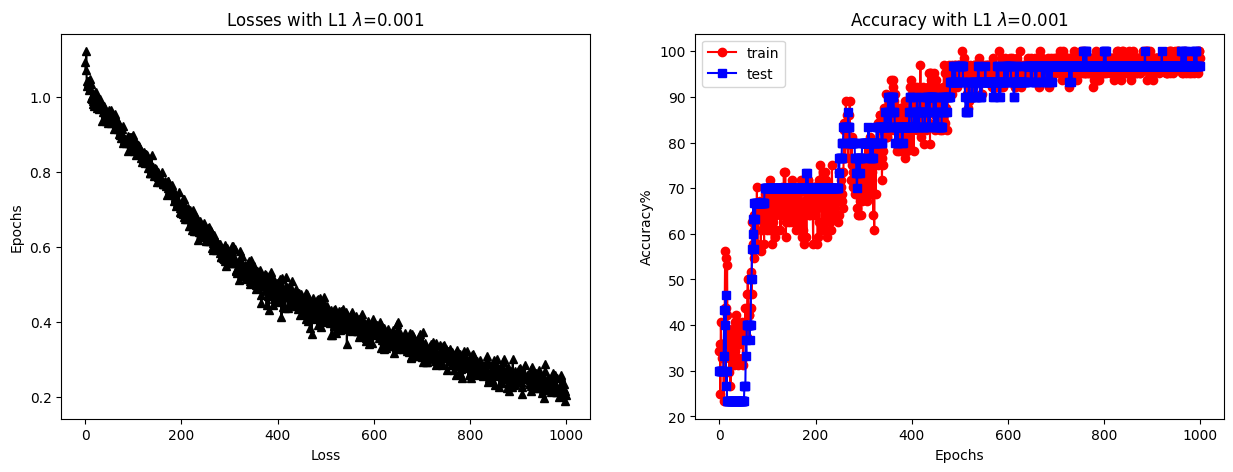

In [44]:
fig,ax = plt.subplots(1,2,figsize =(15,5))
ax[0].plot(losses,'k^-')
ax[0].set_xlabel('Loss')
ax[0].set_ylabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$='+str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy%')
ax[1].set_title('Accuracy with L1 $\lambda$='+str(L1lambda))
ax[1].legend(['train','test'])

In [45]:
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode= 'same')

In [46]:
l1lambda = np.linspace(0,.005,10)
accuracyResultsTrain = np.zeros((numepochs,len(l1lambda)))
accuracyResultsTest = np.zeros((numepochs,len(l1lambda)))
for li in range(len(l1lambda)):
  ANNiris,lossfun,optimizer = createANewmodel()
  trainAcc,testAcc,losses = trainmodel(l1lambda[li])
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li] = smooth(testAcc,10)

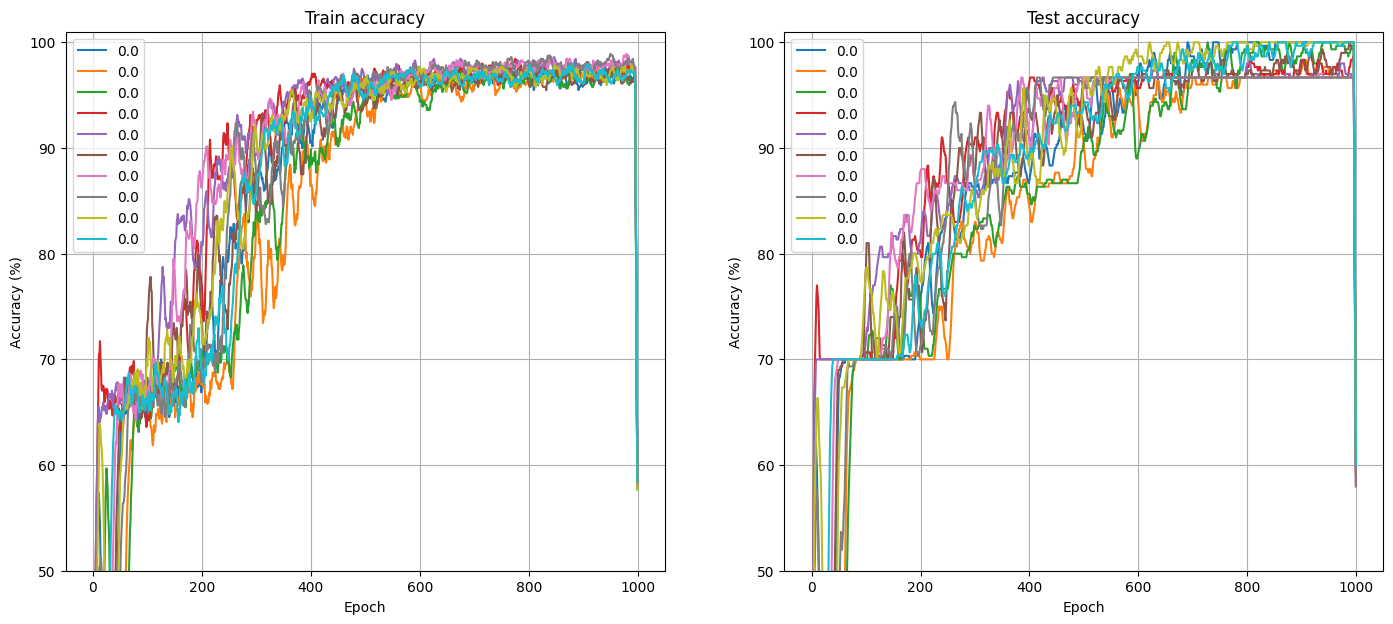

In [47]:
fig,ax = plt.subplots(1,2,figsize=(17,7))
ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

leglabels = [np.round(i,2) for i in l1lambda]
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

Text(0, 0.5, 'Accuracy')

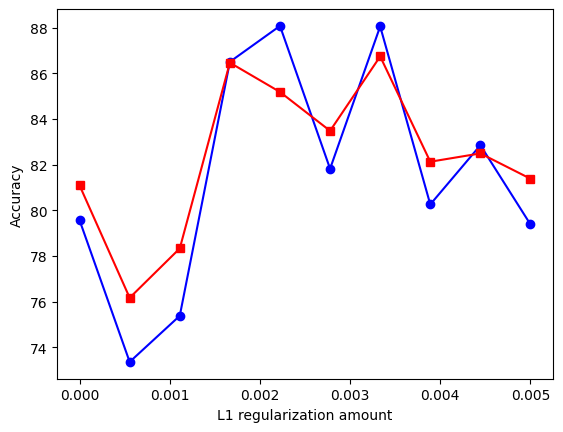

In [48]:
epoch_range = [160,360]
plt.plot(l1lambda,np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis = 0),
         'bo-',label= 'Train')
plt.plot(l1lambda,np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis = 0),
         'rs-',label= 'Test')
plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
